# Clustering

In [18]:
import random
import itertools
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


Utility functions

In [19]:

def debug(thing, title):
    print('--------------------------------------------')
    print(title)
    print(thing)
    print('--------------------------------------------')


def display_imgs(imgs, titles):

    for ind, img in enumerate(imgs):
        print(img.shape)
        if len(img.shape) > 2:
            b,g,r = cv.split(img)
            img = cv.merge((r,g,b))
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')
        plt.title(titles[ind])
        plt.show()


## K-means from scratch

/var/folders/3s/s_cfgxk120b8xn2g6y1m9psw0000gn/T/ipykernel_13454/863821653.py:52: RuntimeWarning: overflow encountered in scalar subtract
  (b2 - b1) ** 2)) ** 0.5
/var/folders/3s/s_cfgxk120b8xn2g6y1m9psw0000gn/T/ipykernel_13454/863821653.py:50: RuntimeWarning: overflow encountered in scalar subtract
  curr_dist = (((r2 - r1) ** 2 +
/var/folders/3s/s_cfgxk120b8xn2g6y1m9psw0000gn/T/ipykernel_13454/863821653.py:51: RuntimeWarning: overflow encountered in scalar subtract
  (g2 - g1) ** 2 +


(51, 90, 3)


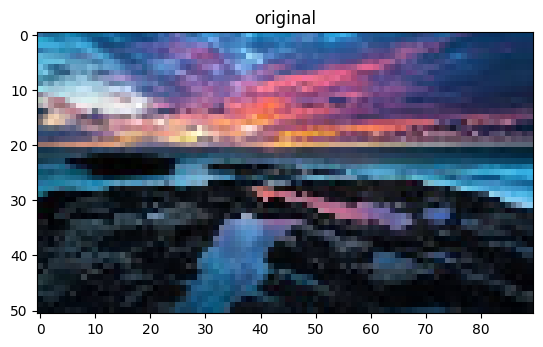

(51, 90, 3)


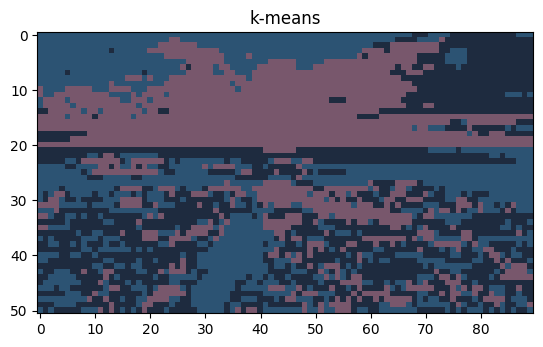

In [20]:

# Define N of clusters
# Choose N points randomly as centroids for clusters
# Compare all points against the centroids, by intensity, until we find the closest one, add them to the clusters
# Calculate new centroid
# Continue until all points have been classified


img_color_int = cv.imread('beach.jpeg')

img = cv.resize(img_color_int, (90, 51))


# K-means implementation for image segmentation by hand.
n = 3

# Homework asks for the algorithm to be tailored for color images.
rows, cols, channels = img.shape

coordinates = itertools.product(list(range(rows)), list(range(cols)))
coordinates = [coordinate for coordinate in coordinates]
#debug(coordinates, 'all coordinates 2d')

# means positions could be initialized randomly, but I put the ones that work well for 
# this image.
#means_pos = random.sample(coordinates, n)
means_pos = [(15, 10), (10, 25), (0, 0)]
means =[img[x, y, :] for x, y in means_pos]
clusters = [[mean] for mean in means]
marked = {ind: [mean_pos] for ind, mean_pos in enumerate(means_pos)}

# marked positions
marked_poses = []
for pos_list in marked.values():
    marked_poses += pos_list


while len(marked_poses) < rows * cols:
    for cluster_ind, mean in enumerate(means):
        if len(marked_poses) == rows * cols:
            break
        r1, g1, b1 = mean[0], mean[1], mean[2]
        min_dist = float('Inf')
        for i in range(rows):
            for j in range(cols):
                # The distance between 2 points is the
                # Euclidean distance between the intensities
                if (i, j) in marked_poses:
                    continue
                r2, g2, b2 = img[i, j, :]
                curr_dist = (((r2 - r1) ** 2 + 
                            (g2 - g1) ** 2 + 
                            (b2 - b1) ** 2)) ** 0.5
                if curr_dist < min_dist:
                    min_dist = curr_dist
                    # Similar point coordinate
                    spt_coordinate = (i, j)

        marked[cluster_ind] += [spt_coordinate]
        marked_poses = []
        for pos_list in marked.values():
            marked_poses += pos_list
        clusters[cluster_ind] += [img[spt_coordinate[0], spt_coordinate[1], :]]


    # After the closest points have been added to the clusters, we 
    # re-calculate the means
    means =  [np.average(intensity_cluster, axis=0) for intensity_cluster in clusters]
means = [mean.astype('uint8') for mean in means]


kmeans_img = np.zeros(img.shape)
for i in range(n):
    r, g, b = means[i]
    # Gives me all the positions for this cluster.
    for pos in marked[i]:
        kmeans_img[pos[0], pos[1], 0] = r
        kmeans_img[pos[0], pos[1], 1] = g
        kmeans_img[pos[0], pos[1], 2] = b

display_imgs([img, kmeans_img.astype('uint8')], ['original', 'k-means'])

## Fuzzy c-means from scratch

(51, 90, 3)


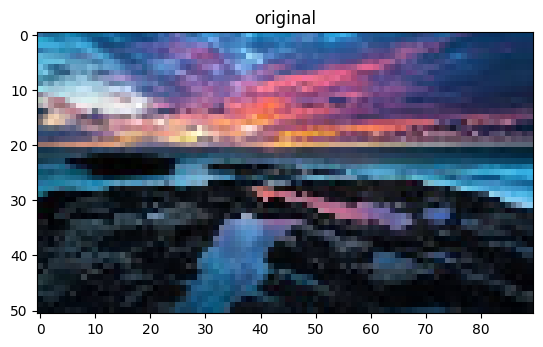

(51, 90, 3)


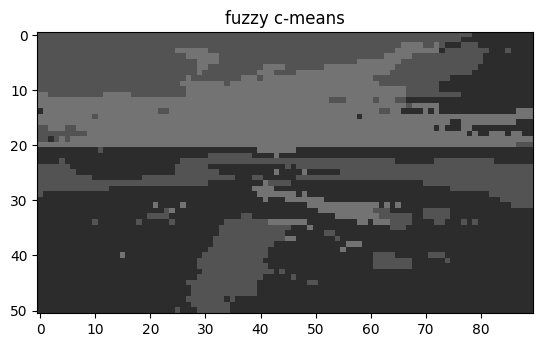

In [21]:

img_color_int = cv.imread('beach.jpeg')

img = cv.resize(img_color_int, (90, 51))


# K-means implementation for image segmentation by hand.
n = 3

# Homework asks for the algorithm to be tailored for color images.
rows, cols, channels = img.shape

coordinates = itertools.product(list(range(rows)), list(range(cols)))
coordinates = [coordinate for coordinate in coordinates]


# means positions could be initialized randomly, but I put the ones that work well for 
# this image
#means_pos = random.sample(coordinates, n)
#means =[img[x, y, :] for x, y in means_pos]
means = [ (0, 0, 255), (255, 0, 0), (0, 255, 0)]


clusters = [[mean] for mean in means]
mem = np.zeros((rows, cols, n))

for _ in range(2):
    for cluster_ind, mean1 in enumerate(means):
        perfect_matches = set()
        # Calculate fuzzy membership values for all the pixels.
        for i in range(rows):
            for j in range(cols):
                if (i, j) in perfect_matches:
                    continue
                r1, g1, b1 = img[i, j, :]
                r2, g2, b2 = mean1
                # Distance to cluster
                d2c = (((r2 - r1) ** 2 + 
                            (g2 - g1) ** 2 + 
                            (b2 - b1) ** 2)) ** 0.5
                if d2c == 0:
                    mem[i, j, cluster_ind] = 1
                    perfect_matches.add((i, j))
                    continue
                denom = 0
                for mean2 in means:
                    r2, g2, b2 = mean2
                    # Distance to cluster 2
                    d2c2 = (((r2 - r1) ** 2 + 
                            (g2 - g1) ** 2 + 
                            (b2 - b1) ** 2)) ** 0.5
                    denom += d2c / d2c2

                mem[i, j, cluster_ind] = 1 / denom
    
    for cluster_ind, mean1 in enumerate(means):
        # After the fuzzy membership has been calculated, we re-calculate the centers.
        num = 0
        denom = 0
        for i in range(rows):
            for j in range(cols):
                num += mem[i, j, cluster_ind] * img[i, j, :]
                denom += mem[i, j, cluster_ind]
        new_mean = np.array(num / denom)
        means[cluster_ind] = new_mean

means = [mean.astype('uint8') for mean in means]

fuzzy_cmeans_img = np.zeros(img.shape)

for i in range(rows):
    for j in range(cols):
        max_membership = float('-Inf')
        cluster_ind = None
        for cluster_ind in range(n):
            curr_mem = mem[i, j, cluster_ind]
            if curr_mem > max_membership:
                max_membership = curr_mem
                # Max membership cluster
                max_mcluster = cluster_ind
            fuzzy_cmeans_img[i, j, :] = mean[max_mcluster]

display_imgs([img, fuzzy_cmeans_img.astype('uint8')], ['original', 'fuzzy c-means'])

In [22]:
# We save the outputs for future activities
cv.imwrite('kmeans_img.png', kmeans_img)
cv.imwrite('fuzzy_cmeans_img.png', fuzzy_cmeans_img)

True